In [1]:
# 📦 Gerekli kütüphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import gradio as gr

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

nltk.download('stopwords')
turkce_stopwords = set(stopwords.words('turkish'))


C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrnck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 🧹 Metin temizleme fonksiyonu
def temizle(yorum):
    yorum = str(yorum).lower()
    yorum = re.sub(r"http\\S+", "", yorum)
    yorum = re.sub(r"[^a-zçğıöşü0-9\\s]", "", yorum)
    yorum = re.sub(r"\\s+", " ", yorum).strip()
    yorum = " ".join([w for w in yorum.split() if w not in turkce_stopwords])
    return yorum


In [3]:
# 🗃️ Veri setini yükleme ve temizleme işlemleri
df = pd.read_csv("eticaret-urun-yorumlari.csv", sep=";")
df.columns = ["Metin", "Durum"]
df = df[df["Durum"].isin([0, 1])]
df["temiz_yorum"] = df["Metin"].apply(temizle)
df = df[df["temiz_yorum"].str.len() > 5]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


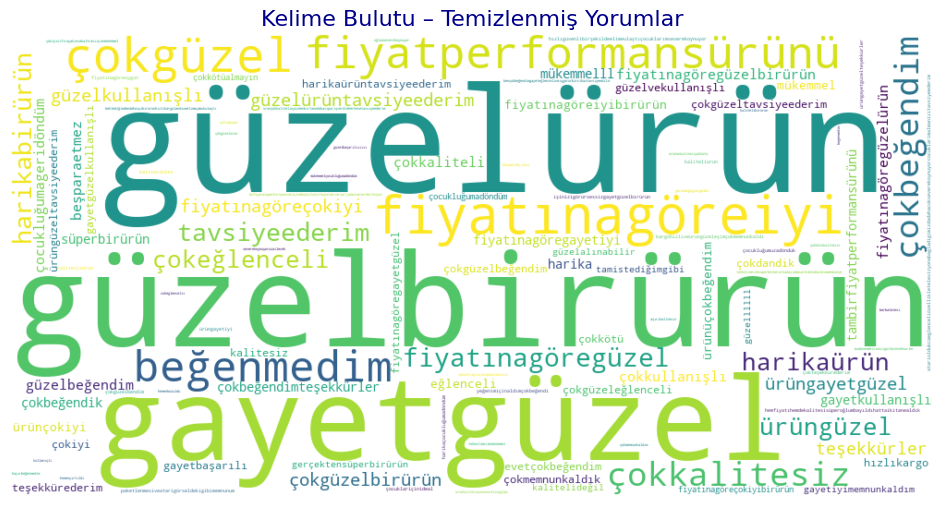

In [4]:
# ☁️ Kelime bulutu ile genel görünüm
wc = WordCloud(width=1000, height=500, background_color='white', colormap='viridis', max_words=200).generate(" ".join(df["temiz_yorum"]))
plt.figure(figsize=(14, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Kelime Bulutu – Temizlenmiş Yorumlar", fontsize=16, color="darkblue")
plt.show()


In [5]:
# 📊 Eğitim ve test verisinin ayrılması (60% eğitim, 40% test)
X_train, X_test, y_train, y_test = train_test_split(df["temiz_yorum"], df["Durum"], test_size=0.4, random_state=42)


In [6]:
# 🔤 TF-IDF ile n-gram (1,2) bazlı vektörleştirme
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [7]:
# 🧠 Multinomial Naive Bayes modeliyle eğitim
model = MultinomialNB()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("Doğruluk:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Doğruluk: 0.5424314010539706
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      2795
           1       0.99      0.07      0.13      2708

    accuracy                           0.54      5503
   macro avg       0.76      0.54      0.41      5503
weighted avg       0.75      0.54      0.42      5503



In [8]:
# 🧠 MultinomialNB modeli için özel vektörleştirme ve eğitim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Yeni TF-IDF (naive bayes için özel)
vectorizer_nb = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X_train_vec_nb = vectorizer_nb.fit_transform(X_train)
X_test_vec_nb = vectorizer_nb.transform(X_test)

# Modeli eğit
model_nb = MultinomialNB()
model_nb.fit(X_train_vec_nb, y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


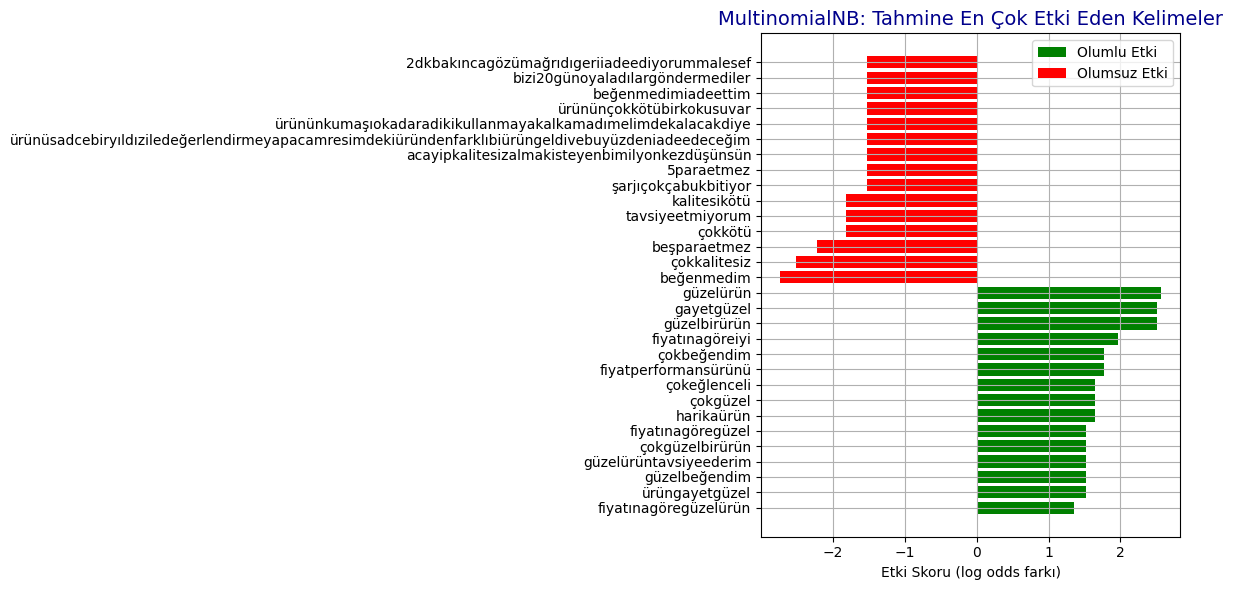

In [9]:
# 🔍 En Etkili Kelimeleri Görselleştir – MultinomialNB (Log odds farkı)
import numpy as np
import matplotlib.pyplot as plt

log_probs = model_nb.feature_log_prob_
importance = log_probs[1] - log_probs[0]  # Olumlu - Olumsuz

# En olumlu ve olumsuz kelimeleri sırala
top_positive_idx = np.argsort(importance)[-15:]
top_negative_idx = np.argsort(importance)[:15]

feature_names = np.array(vectorizer_nb.get_feature_names_out())
top_pos_words = feature_names[top_positive_idx]
top_pos_values = importance[top_positive_idx]
top_neg_words = feature_names[top_negative_idx]
top_neg_values = importance[top_negative_idx]

# Grafik çiz
plt.figure(figsize=(12, 6))
plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
plt.title("MultinomialNB: Tahmine En Çok Etki Eden Kelimeler", fontsize=14, color="darkblue")
plt.xlabel("Etki Skoru (log odds farkı)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\yrnck\AppData\Local\Temp\ipykernel_13728\2343720274.py:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


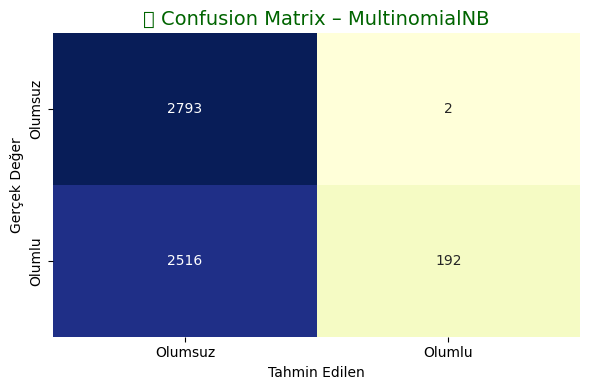

In [10]:
# 📉 Confusion Matrix – Isı haritası şeklinde görselleştirme
cm = confusion_matrix(y_test, y_pred)
etiketler = ["Olumsuz", "Olumlu"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=etiketler, yticklabels=etiketler, cbar=False)
plt.title("🎯 Confusion Matrix – MultinomialNB", fontsize=14, color="darkgreen")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.tight_layout()
plt.show()


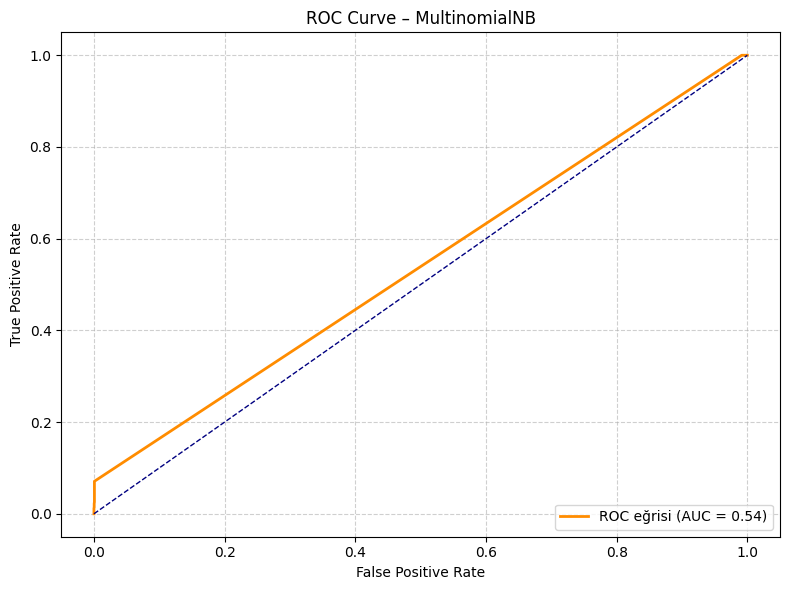

In [11]:
# 🚀 ROC Eğrisi (Receiver Operating Characteristic)
y_probs = model.predict_proba(X_test_vec)[:, 1]  # Olumlu sınıf olasılığı
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC eğrisi (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – MultinomialNB")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


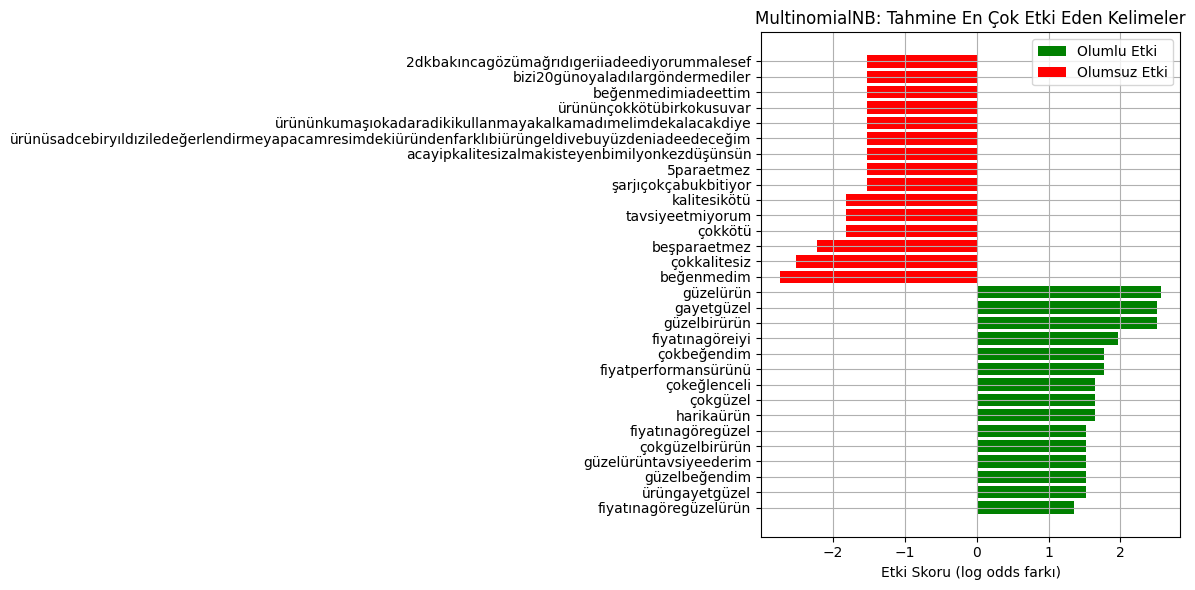

In [12]:
# 🔍 Tahmini etkileyen en önemli kelimeleri göster
log_probs = model.feature_log_prob_
importance = log_probs[1] - log_probs[0]

top_positive_idx = np.argsort(importance)[-15:]
top_negative_idx = np.argsort(importance)[:15]

feature_names = np.array(vectorizer.get_feature_names_out())
top_pos_words = feature_names[top_positive_idx]
top_pos_values = importance[top_positive_idx]
top_neg_words = feature_names[top_negative_idx]
top_neg_values = importance[top_negative_idx]

plt.figure(figsize=(12, 6))
plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
plt.title("MultinomialNB: Tahmine En Çok Etki Eden Kelimeler")
plt.xlabel("Etki Skoru (log odds farkı)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\yrnck\AppData\Local\Temp\ipykernel_13728\2808929286.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


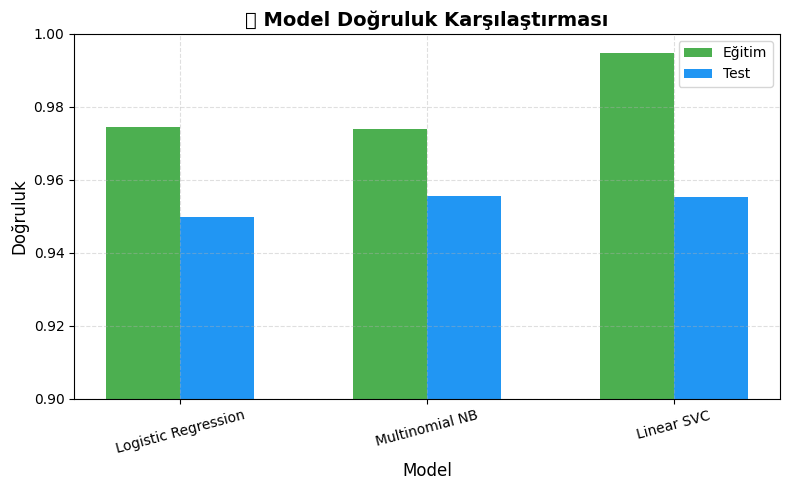

In [13]:
# 🧪 Farklı modellerin doğruluk karşılaştırma grafiği
data = {
    "Model": ["Logistic Regression", "Multinomial NB", "Linear SVC"],
    "Eğitim Doğruluğu": [0.9744, 0.9740, 0.9948],
    "Test Doğruluğu": [0.9497, 0.9556, 0.9552]
}

df_karsilastirma = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
bar_width = 0.3
index = np.arange(len(df_karsilastirma))

plt.bar(index, df_karsilastirma["Eğitim Doğruluğu"], bar_width, label="Eğitim", color="#4CAF50")
plt.bar(index + bar_width, df_karsilastirma["Test Doğruluğu"], bar_width, label="Test", color="#2196F3")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Doğruluk", fontsize=12)
plt.title("📊 Model Doğruluk Karşılaştırması", fontsize=14, weight="bold")
plt.xticks(index + bar_width / 2, df_karsilastirma["Model"], rotation=15)
plt.ylim(0.90, 1.00)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [14]:
# 📲 Gradio Sekmeli Arayüz: Tahmin + Performans + Model Karşılaştırması + Etkili Kelimeler
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 🎯 Model Karşılaştırma Grafiği Fonksiyonu
def model_karsilastirma_grafigi():
    data = {
        "Model": ["Logistic Regression", "Multinomial NB", "Linear SVC"],
        "Eğitim Doğruluğu": [0.9744, 0.9740, 0.9948],
        "Test Doğruluğu": [0.9497, 0.9556, 0.9552]
    }
    df = pd.DataFrame(data)
    plt.figure(figsize=(8, 5))
    bar_width = 0.3
    index = np.arange(len(df))

    plt.bar(index, df["Eğitim Doğruluğu"], bar_width, label="Eğitim", color="#4CAF50")
    plt.bar(index + bar_width, df["Test Doğruluğu"], bar_width, label="Test", color="#2196F3")

    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Doğruluk", fontsize=12)
    plt.title("Model Doğruluk Karşılaştırması", fontsize=14, weight="bold")
    plt.xticks(index + bar_width / 2, df["Model"], rotation=15)
    plt.ylim(0.90, 1.00)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    path = "model_karsilastirma.png"
    plt.savefig(path)
    plt.close()
    return path

# 📌 En Etkili Kelimeler Görselleştirme
def etkili_kelimeler_grafigi():
    log_probs = model_nb.feature_log_prob_
    importance = log_probs[1] - log_probs[0]

    top_positive_idx = np.argsort(importance)[-15:]
    top_negative_idx = np.argsort(importance)[:15]

    feature_names = np.array(vectorizer_nb.get_feature_names_out())
    top_pos_words = feature_names[top_positive_idx]
    top_pos_values = importance[top_positive_idx]
    top_neg_words = feature_names[top_negative_idx]
    top_neg_values = importance[top_negative_idx]

    plt.figure(figsize=(12, 6))
    plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
    plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
    plt.title("MultinomialNB: Tahmine En Çok Etki Eden Kelimeler")
    plt.xlabel("Etki Skoru (log odds farkı)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    path = "etkili_kelimeler.png"
    plt.savefig(path)
    plt.close()
    return path

# 🎛️ Gradio Arayüzü
with gr.Blocks(theme=gr.themes.Soft()) as demo:

    # 🛍️ Tahmin Sekmesi (kullanıcı kaldırmak istemişti)
    with gr.Tab("📊 Performans"):
        gr.Markdown("### Model Performansı\nEğitim/Test doğruluğu ve AUC skoru")

        def performans_ozeti():
            train_acc = model.score(X_train_vec, y_train)
            test_acc = model.score(X_test_vec, y_test)
            y_probs = model.predict_proba(X_test_vec)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_probs)
            roc_auc_val = auc(fpr, tpr)

            return f"""
            <div style='font-size:16px'>
                <b>📘 Eğitim Doğruluğu:</b> %{train_acc*100:.2f}<br>
                <b>📗 Test Doğruluğu:</b> %{test_acc*100:.2f}<br>
                <b>📈 AUC Skoru:</b> {roc_auc_val:.3f}<br><br>
                <i>Model: Multinomial Naive Bayes</i>
            </div>
            """

        performans_output = gr.HTML()
        gr.Button("Performansı Göster").click(fn=performans_ozeti, outputs=performans_output)

    # 📉 Model Karşılaştırması Sekmesi
    with gr.Tab("📉 Model Karşılaştırması"):
        gr.Markdown("### Modellerin Eğitim ve Test Başarıları (Görsel)")
        grafik_output = gr.Image(label="Model Karşılaştırma Grafiği")
        gr.Button("Grafiği Göster").click(fn=model_karsilastirma_grafigi, outputs=grafik_output)

    # 🔍 En Etkili Kelimeler Sekmesi
    with gr.Tab("🧠 En Etkili Kelimeler"):
        gr.Markdown("### MultinomialNB ile Tahmine En Çok Etki Eden Kelimeler")
        kelime_output = gr.Image(label="Etki Skoru ile Kelimeler")
        gr.Button("Kelime Grafiğini Göster").click(fn=etkili_kelimeler_grafigi, outputs=kelime_output)

# 🚀 Arayüzü başlat
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [15]:
print(f"Toplam yorum sayısı: {len(df)}")
print(df['Durum'].value_counts())

Toplam yorum sayısı: 13756
Durum
0    6975
1    6781
Name: count, dtype: int64
